# This notebook shows how to performa heteroscedastic lengthscale, variance, and noise solve

In [1]:
from ionotomo import *
import numpy as np
import pylab as plt
plt.style.use('ggplot')
import astropy.units as au
import os

import gpflow as gp
from doubly_stochastic_dgp.dgp import DGP
from scipy.cluster.vq import kmeans2
import logging
logging.basicConfig(format='%(asctime)s %(message)s')
import h5py
import tensorflow as tf

import seaborn as sns
import pandas as pd

/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home/josh/anaconda3/envs/kerastf/lib/python3.6/site-packages/multipledispatch-0.4.9-py3.6.egg/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Linear, NoneType, Sum, InducingPoints], [Gaussian, Identity, NoneType, Kernel, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Su

In [2]:
from gpflow import settings,  densities, transforms, kullback_leiblers, features, conditionals
from gpflow.core.compilable import Build
from gpflow.params import Parameterized, ParamList, DataHolder, Parameter, Minibatch, DataHolder
from gpflow.decors import autoflow,params_as_tensors, params_as_tensors_for
from gpflow.mean_functions import Zero
from gpflow.models import SVGP
from gpflow.quadrature import hermgauss
from gpflow.likelihoods import Likelihood, SwitchedLikelihood
from gpflow.actions import Loop, Action
from gpflow.training import NatGradOptimizer, AdamOptimizer, XiSqrtMeanVar
from gpflow.kernels import Kernel

class NonstationaryKernel(Kernel):
    def __init__(self,input_dim, Z=None, hetero_sigma=True, hetero_ls=True,  active_dims=None, name=None):
        super(NonstationaryKernel, self).__init__(input_dim, active_dims, name=name)
        self.hetero_sigma = hetero_sigma
        self.hetero_ls = hetero_ls
        if hetero_sigma:
            assert Z is not None, "Requires inducing points"
            mean = gp.mean_functions.Constant(1.)
            kern = gp.kernels.RBF(input_dim,active_dims=active_dims,variance=0.1,name='hetero_sigma_kern')
            kern.variance.set_trainable(False)# = gp.priors.Gaussian(0.,0.1)
            self.sigma_latent = PositiveHeteroscedasticLatent(Z, mean, kern, feat=None, q_diag=False, whiten=True, name="hetero_sigma_latent")
        else:
            self.stationary_sigma = Parameter(1., transform=transforms.positive)
        if hetero_ls:
            assert Z is not None, "Requires inducing points"
            mean = gp.mean_functions.Constant(1.)
            kern = gp.kernels.RBF(input_dim,active_dims=active_dims,variance=0.1,name='hetero_ls_kern')
            kern.variance.set_trainable(False)# = gp.priors.Gaussian(0.,0.1)
            self.ls_latent = PositiveHeteroscedasticLatent(Z, mean, kern, feat=None, q_diag=False, whiten=True, name="hetero_ls_latent")
        else:
            self.stationary_ls = Parameter(1., transform=transforms.positive)
            
    @params_as_tensors
    def Kdiag(self, X, presliced=False):
        if not presliced:
            X, _ = self._slice(X, None)
            
        if self.hetero_sigma:
            sigma = self.sigma_latent.predict_f_samples(X)[0,:,0]#K
        else:
            sigma = self.stationary_sigma * tf.ones(tf.stack([tf.shape(X)[0]]),dtype=settings.float_type)
        
        Kdiag = sigma**2 #tf.fill(tf.stack([tf.shape(X)[0]]), 1.)
        return Kdiag
    
    @params_as_tensors
    def K(self, X, X2=None, presliced=False):
        if not presliced:
            X, X2 = self._slice(X, X2)
        
        if X2 is not None:
            X_ = [X,X2]
        else:
            X_ = X
        X_len = tf.shape(X)[0]
        if self.hetero_ls:
            ls_ = self.ls_latent.predict_f_samples(X_)#SN1
            if X2 is not None:
                ls = ls_[0,:X_len,:]#N1
                ls2 = tf.transpose(ls_[0,X_len:,:])#1K
            else:
                ls = ls_[0,:,:]#N1
                ls2 = tf.transpose(ls)#1N
        else:
            ls = self.stationary_ls
            ls2 = ls
        if self.hetero_sigma:
            sigma_ = self.sigma_latent.predict_f_samples(X_)#M1
            if X2 is not None:
                sigma = sigma_[0,:X_len,:]#N1
                sigma2 = tf.transpose(sigma_[0,X_len:,:])#N1)#1K
            else:
                sigma = sigma_[0,:,:]#N1
                sigma2 = tf.transpose(sigma)#1N
        else:
            sigma = self.stationary_sigma
            sigma2 = sigma

#         if X2 is None:
#             X2 = X
#         dist = (X-tf.transpose(X2))**2
#         lmag = ls**2 + ls2**2
#         K = tf.sqrt(2. * (ls*ls2)/lmag)*tf.exp(-dist/lmag)
#         return K

        dist = self.square_dist(X,X2)#NK
        l_mag = ls**2 + ls2**2#NK
        K = sigma*sigma2*tf.sqrt(2.*(ls*ls2)/l_mag) * tf.exp(-dist/l_mag)
        return K
                   
    @params_as_tensors       
    def square_dist(self, X, X2):
        """
        Returns ((X - X2ᵀ)/lengthscales)².
        Due to the implementation and floating-point imprecision, the
        result may actually be very slightly negative for entries very
        close to each other.
        """
        X = X
        Xs = tf.reduce_sum(tf.square(X), axis=1)

        if X2 is None:
            dist = -2 * tf.matmul(X, X, transpose_b=True)
            dist += tf.reshape(Xs, (-1, 1))  + tf.reshape(Xs, (1, -1))
            return dist

        X2 = X2
        X2s = tf.reduce_sum(tf.square(X2), axis=1)
        dist = -2 * tf.matmul(X, X2, transpose_b=True)
        dist += tf.reshape(Xs, (-1, 1)) + tf.reshape(X2s, (1, -1))
        return dist

    
class WrappedPhaseGaussian(Likelihood):
    def __init__(self, freq, var=1.0, name=None):
        super().__init__(name=name)
        self.freq = freq # frequency the phase is defined at
        self.tec_conversion = -8.4480e9 # rad Hz/ tecu
        self.tec2phase = tf.convert_to_tensor(self.tec_conversion / self.freq,dtype=settings.float_type,name='tec2phase')
        self.variance = gp.params.Parameter(
            var, transform=transforms.positive, dtype=settings.float_type)
        
    def wrap(self, f):
        """Wraps f into (-pi, pi)"""
        return tf.cast(tf.atan2(tf.sin(f),tf.cos(f)),settings.float_type)
    
    @params_as_tensors
    def logp(self, F, Y):
        """The log-likelihood function."""
        phase = self.wrap(F*self.tec2phase)
        dphase = self.wrap(phase - self.wrap(Y)) # Ito theorem
        return densities.gaussian(dphase, tf.fill(tf.shape(F),tf.cast(0.,settings.float_type)), self.variance)

    @params_as_tensors
    def conditional_mean(self, F):  # pylint: disable=R0201
        """The mean of the likelihood conditioned on latent."""
        phase = F*self.tec2phase
        return phase

    @params_as_tensors
    def conditional_variance(self, F):
        return tf.fill(tf.shape(F), tf.squeeze(self.variance))

class HeteroscedasticLikelihood_old(Likelihood):
    def __init__(self, name=None):
        super().__init__(name=name)
        
    @params_as_tensors
    def logp(self, F, Y, hetero_variance, *unused_args):
        """The log-likelihood function."""
        raise NotImplemented("sub class must...")

    @params_as_tensors
    def conditional_mean(self, F, *unused_args):  # pylint: disable=R0201
        """The mean of the likelihood conditioned on latent."""
        raise NotImplemented("sub class must...")

    @params_as_tensors
    def conditional_variance(self, F, hetero_variance, *unused_args): # pylint: disable=R0201
        """The var of the likelihood conditioned on latent."""
        raise NotImplemented("sub class must...")

    def predict_mean_and_var(self, Fmu, Fvar,hetero_variance, *args):
        """
        Given a Normal distribution for the latent function,
        return the mean of Y
        if
            q(f) = N(Fmu, Fvar)
        and this object represents
            p(y|f)
        then this method computes the predictive mean
           \int\int y p(y|f)q(f) df dy
        and the predictive variance
           \int\int y^2 p(y|f)q(f) df dy  - [ \int\int y p(y|f)q(f) df dy ]^2
        Here, we implement a default Gauss-Hermite quadrature routine, but some
        likelihoods (e.g. Gaussian) will implement specific cases.
        """
        gh_x, gh_w = hermgauss(self.num_gauss_hermite_points)
        gh_w /= np.sqrt(np.pi)
        gh_w = gh_w.reshape(-1, 1)
        shape = tf.shape(Fmu)
        Fmu, Fvar,hetero_variance = [tf.reshape(e, (-1, 1)) for e in (Fmu, Fvar,hetero_variance)]
        X = gh_x[None, :] * tf.sqrt(2.0 * Fvar) + Fmu

        # here's the quadrature for the mean
        E_y = tf.reshape(tf.matmul(self.conditional_mean(X), gh_w), shape)

        # here's the quadrature for the variance
        integrand = self.conditional_variance(X,hetero_variance, *args) \
            + tf.square(self.conditional_mean(X, *args))
        V_y = tf.reshape(tf.matmul(integrand, gh_w), shape) - tf.square(E_y)

        return E_y, V_y
    
    def predict_density(self, Fmu, Fvar, Y,hetero_variance, *args):
        """
        Given a Normal distribution for the latent function, and a datum Y,
        compute the (log) predictive density of Y.
        i.e. if
            q(f) = N(Fmu, Fvar)
        and this object represents
            p(y|f)
        then this method computes the predictive density
           \int p(y=Y|f)q(f) df
        Here, we implement a default Gauss-Hermite quadrature routine, but some
        likelihoods (Gaussian, Poisson) will implement specific cases.
        """
        gh_x, gh_w = hermgauss(self.num_gauss_hermite_points)

        gh_w = gh_w.reshape(-1, 1) / np.sqrt(np.pi)
        shape = tf.shape(Fmu)
        Fmu, Fvar, Y, hetero_variance = [tf.reshape(e, (-1, 1)) for e in (Fmu, Fvar, Y, hetero_variance)]
        X = gh_x[None, :] * tf.sqrt(2.0 * Fvar) + Fmu

        Y = tf.tile(Y, [1, self.num_gauss_hermite_points])  # broadcast Y to match X

        logp = self.logp(X, Y, hetero_variance, *args)
        return tf.reshape(tf.log(tf.matmul(tf.exp(logp), gh_w)), shape)

    @params_as_tensors
    def variational_expectations(self, Fmu, Fvar, Y, hetero_variance, *args):
        """
        Compute the expected log density of the data, given a Gaussian
        distribution for the function values.
        if
            q(f) = N(Fmu, Fvar)
        and this object represents
            p(y|f)
        then this method computes
           \int (\log p(y|f)) q(f) df.
        Here, we implement a default Gauss-Hermite quadrature routine, but some
        likelihoods (Gaussian, Poisson) will implement specific cases.
        """
        gh_x, gh_w = hermgauss(self.num_gauss_hermite_points)
        gh_x = gh_x.reshape(1, -1)
        gh_w = gh_w.reshape(-1, 1) / np.sqrt(np.pi)
        shape = tf.shape(Fmu)
        Fmu, Fvar, Y, hetero_variance = [tf.reshape(e, (-1, 1)) for e in (Fmu, Fvar, Y, hetero_variance)]
        X = gh_x * tf.sqrt(2.0 * Fvar) + Fmu
        Y = tf.tile(Y, [1, self.num_gauss_hermite_points])  # broadcast Y to match X
        logp = self.logp(X, Y,hetero_variance, *args)
        return tf.reshape(tf.matmul(logp, gh_w), shape)

class HeteroscedasticLikelihood(Likelihood):
    def __init__(self, name=None):
        super().__init__(name=name)
        
    @params_as_tensors
    def logp(self, F, Y, *args):
        """The log-likelihood function."""
        raise NotImplemented("sub class must...")

    @params_as_tensors
    def conditional_mean(self, F, *args):  # pylint: disable=R0201
        """The mean of the likelihood conditioned on latent."""
        raise NotImplemented("sub class must...")

    @params_as_tensors
    def conditional_variance(self, F, *args): # pylint: disable=R0201
        """The var of the likelihood conditioned on latent."""
        raise NotImplemented("sub class must...")

    def predict_mean_and_var(self, Fmu, Fvar,*args):
        """
        Given a Normal distribution for the latent function,
        return the mean of Y
        if
            q(f) = N(Fmu, Fvar)
        and this object represents
            p(y|f)
        then this method computes the predictive mean
           \int\int y p(y|f)q(f) df dy
        and the predictive variance
           \int\int y^2 p(y|f)q(f) df dy  - [ \int\int y p(y|f)q(f) df dy ]^2
        Here, we implement a default Gauss-Hermite quadrature routine, but some
        likelihoods (e.g. Gaussian) will implement specific cases.
        """
        gh_x, gh_w = hermgauss(self.num_gauss_hermite_points)
        gh_w /= np.sqrt(np.pi)
        gh_w = gh_w.reshape(-1, 1)
        shape = tf.shape(Fmu)
        Fmu, Fvar = [tf.reshape(e, (-1, 1)) for e in (Fmu, Fvar)]
        # each element of arg must have same number of latent
        # TODO  tile to match latent if not already
        args = [tf.reshape(e, (-1, 1)) if isinstance(e,tf.Tensor) else e for e in args]
        X = gh_x[None, :] * tf.sqrt(2.0 * Fvar) + Fmu

        # here's the quadrature for the mean
        conditional_mean = self.conditional_mean(X,*args)
        E_y = tf.reshape(tf.matmul(conditional_mean, gh_w), shape)

        # here's the quadrature for the variance
        integrand = self.conditional_variance(X, *args) \
            + tf.square(conditional_mean)
        V_y = tf.reshape(tf.matmul(integrand, gh_w), shape) - tf.square(E_y)

        return E_y, V_y
    
    def predict_density(self, Fmu, Fvar, Y, *args):
        """
        Given a Normal distribution for the latent function, and a datum Y,
        compute the (log) predictive density of Y.
        i.e. if
            q(f) = N(Fmu, Fvar)
        and this object represents
            p(y|f)
        then this method computes the predictive density
           \int p(y=Y|f)q(f) df
        Here, we implement a default Gauss-Hermite quadrature routine, but some
        likelihoods (Gaussian, Poisson) will implement specific cases.
        """
        gh_x, gh_w = hermgauss(self.num_gauss_hermite_points)

        gh_w = gh_w.reshape(-1, 1) / np.sqrt(np.pi)
        shape = tf.shape(Fmu)
        Fmu, Fvar, Y = [tf.reshape(e, (-1, 1)) for e in (Fmu, Fvar, Y)]
        args = [tf.reshape(e, (-1, 1)) if isinstance(e,tf.Tensor) else e for e in args]
        X = gh_x[None, :] * tf.sqrt(2.0 * Fvar) + Fmu

        Y = tf.tile(Y, [1, self.num_gauss_hermite_points])  # broadcast Y to match X

        logp = self.logp(X, Y, *args)
        return tf.reshape(tf.log(tf.matmul(tf.exp(logp), gh_w)), shape)

    @params_as_tensors
    def variational_expectations(self, Fmu, Fvar, Y, *args):
        """
        Compute the expected log density of the data, given a Gaussian
        distribution for the function values.
        if
            q(f) = N(Fmu, Fvar)
        and this object represents
            p(y|f)
        then this method computes
           \int (\log p(y|f)) q(f) df.
        Here, we implement a default Gauss-Hermite quadrature routine, but some
        likelihoods (Gaussian, Poisson) will implement specific cases.
        """
        gh_x, gh_w = hermgauss(self.num_gauss_hermite_points)
        gh_x = gh_x.reshape(1, -1)
        gh_w = gh_w.reshape(-1, 1) / np.sqrt(np.pi)
        shape = tf.shape(Fmu)
        Fmu, Fvar, Y = [tf.reshape(e, (-1, 1)) for e in (Fmu, Fvar, Y)]
        args = [tf.reshape(e, (-1, 1)) if isinstance(e,tf.Tensor) else e for e in args]
        X = gh_x * tf.sqrt(2.0 * Fvar) + Fmu
        Y = tf.tile(Y, [1, self.num_gauss_hermite_points])  # broadcast Y to match X
        logp = self.logp(X, Y, *args)
        return tf.reshape(tf.matmul(logp, gh_w), shape)
    
    
class HeteroscedasticSwitchedLikelihood(HeteroscedasticLikelihood):
    def __init__(self, likelihood_list):
        """
        In this likelihood, we assume at extra column of Y, which contains
        integers that specify a likelihood from the list of likelihoods.
        """
        Likelihood.__init__(self)
        for l in likelihood_list:
            assert isinstance(l, Likelihood)
        self.likelihood_list = ParamList(likelihood_list)
        self.num_likelihoods = len(self.likelihood_list)

    def _partition_and_stitch(self, args, func_name):
        """
        args is a list of tensors, to be passed to self.likelihoods.<func_name>
        args[-2] is the 'Y' argument, which contains the indexes to self.likelihoods.
        This function splits up the args using dynamic_partition, calls the
        relevant function on the likelihoods, and re-combines the result.
        """
        # get the index from Y
        Y = args[-2]
        ind = Y[:, -1]
        ind = tf.cast(ind, tf.int32)
        Y = Y[:, :-1]
        args[-2] = Y

        # split up the arguments into chunks corresponding to the relevant likelihoods
        args = zip(*[tf.dynamic_partition(X, ind, self.num_likelihoods) for X in args])

        # apply the likelihood-function to each section of the data
        with params_as_tensors_for(self, convert=False):
            funcs = [getattr(lik, func_name) for lik in self.likelihood_list]
        results = [f(*args_i) for f, args_i in zip(funcs, args)]

        # stitch the results back together
        partitions = tf.dynamic_partition(tf.range(0, tf.size(ind)), ind, self.num_likelihoods)
        results = tf.dynamic_stitch(partitions, results)

        return results

    def logp(self, F, Y, hetero_variance):
        return self._partition_and_stitch([F, Y, hetero_variance], 'logp')

    def predict_density(self, Fmu, Fvar, Y, hetero_variance):
        return self._partition_and_stitch([Fmu, Fvar, Y, hetero_variance], 'predict_density')

    def variational_expectations(self, Fmu, Fvar, Y, hetero_variance):
        return self._partition_and_stitch([Fmu, Fvar, Y, hetero_variance], 'variational_expectations')

    def predict_mean_and_var(self, Fmu, Fvar, hetero_variance):
        mvs = [lik.predict_mean_and_var(Fmu, Fvar, hetero_variance) for lik in self.likelihood_list]
        mu_list, var_list = zip(*mvs)
        mu = tf.concat(mu_list, 1)
        var = tf.concat(var_list, 1)
        return mu, var

class HeteroscedasticWrappedPhaseGaussian(HeteroscedasticLikelihood):
    def __init__(self, freq=140e6, name=None):
        super().__init__(name=name)
        self.freq = tf.convert_to_tensor(freq,dtype=settings.float_type,name='test_freq') # frequency the phase is calculated at for the predictive distribution
        self.tec_conversion = tf.convert_to_tensor(-8.4480e9,dtype=settings.float_type,name='tec_conversion') # rad Hz/ tecu
        self.tec2phase = tf.convert_to_tensor(self.tec_conversion / self.freq,dtype=settings.float_type,name='tec2phase')
        
    def wrap(self, f):
        """Wraps f into (-pi, pi)"""
        return tf.cast(tf.atan2(tf.sin(f),tf.cos(f)),settings.float_type)
    
    @params_as_tensors
    def logp(self, F, Y, hetero_variance, freqs, *unused_args):
        """The log-likelihood function."""
        tec2phase = self.tec_conversion/freqs
        phase = self.wrap(F*tec2phase)
        dphase = self.wrap(phase - self.wrap(Y)) # Ito theorem
        return densities.gaussian(dphase, tf.fill(tf.shape(F),tf.cast(0.,settings.float_type)), hetero_variance)

    @params_as_tensors
    def conditional_mean(self, F, unused_hetero_variance, freq, *unused_args):  # pylint: disable=R0201
        """The mean of the likelihood conditioned on latent."""
        freq = self.freq if freq is None else tf.convert_to_tensor(freq,dtype=settings.float_type)
        tec2phase = self.tec_conversion/freq
        phase = F*tec2phase
        return phase

    @params_as_tensors
    def conditional_variance(self, F, hetero_variance, *unused_args):
        return hetero_variance

def make_hetero_likelihood(likelihood,freqs):
    return HeteroscedasticSwitchedLikelihood([likelihood(f,name='freq_{}_likelihood'.format(i)) for i,f in enumerate(freqs)])

def make_likelihood(likelihood,freqs):
    return SwitchedLikelihood([likelihood(f,name='freq_{}_likelihood'.format(i)) for i,f in enumerate(freqs)])

class HeteroscedasticLatent(Parameterized):
    def __init__(self, Z, mean_function, kern, feat=None, q_diag=False, whiten=True, name=None):
        super(HeteroscedasticLatent, self).__init__(name=name)
        self.mean_function = mean_function
        self.kern = kern
        self.num_latent = 1
        
        self.feature = features.inducingpoint_wrapper(feat, Z)
        num_inducing = len(self.feature)
        self.whiten = whiten
        
        self.q_mu = Parameter(np.zeros((num_inducing, self.num_latent), dtype=settings.float_type))
        self.q_diag = q_diag
        if self.q_diag:
            self.q_sqrt = Parameter(np.ones((num_inducing, self.num_latent), dtype=settings.float_type),
                                    transforms.positive)
        else:
            q_sqrt = np.array([np.eye(num_inducing, dtype=settings.float_type)
                               for _ in range(self.num_latent)])
            self.q_sqrt = Parameter(q_sqrt, transform=transforms.LowerTriangular(num_inducing, self.num_latent))
            
    #@autoflow((settings.float_type, [None, None]), (tf.int32, []))
    @params_as_tensors
    def predict_f_samples(self, Xnew, num_samples=1):
        """
        Produce samples from the posterior latent function(s) at the points
        Xnew.
        """
        if isinstance(Xnew,(tuple,list)):
            assert len(Xnew) == 2
            mu0, var0 = self._build_predict(Xnew[0], full_cov=True)
            mu1, var1 = self._build_predict(Xnew[1], full_cov=True)
            mu = tf.concat([mu0,mu1],axis=0)
            N = tf.shape(var0)[0]
            M = tf.shape(var1)[0]
            K = tf.shape(var0)[-1]
            zeros = tf.zeros([N,M,K],dtype=settings.float_type)
            var = tf.concat([
                tf.concat([var0, zeros],axis=1),
                tf.concat([tf.transpose(zeros,(1,0,2)), var1],axis=1)
            ], axis=0)
        else:
            mu, var = self._build_predict(Xnew, full_cov=True)
        jitter = tf.eye(tf.shape(mu)[0], dtype=settings.float_type) * settings.numerics.jitter_level
        samples = []
        for i in range(self.num_latent):
            L = tf.cholesky(var[:, :, i] + jitter)
            shape = tf.stack([tf.shape(L)[0], num_samples])
            V = tf.random_normal(shape, dtype=settings.float_type)
            samples.append(mu[:, i:i + 1] + tf.matmul(L, V))
        return tf.transpose(tf.stack(samples))# S,N,D
    
    @autoflow((settings.float_type, [None, None]))
    def predict_f(self, Xnew):
        """
        Compute the mean and variance of the latent function(s) at the points
        Xnew.
        """
        return self._build_predict(Xnew)

    @autoflow((settings.float_type, [None, None]))
    def predict_f_full_cov(self, Xnew):
        """
        Compute the mean and covariance matrix of the latent function(s) at the
        points Xnew.
        """
        return self._build_predict(Xnew, full_cov=True)

    
    @params_as_tensors
    def _build_predict(self, Xnew, full_cov=False):
        mu, var = features.conditional(self.feature, self.kern, Xnew, self.q_mu,
                                       q_sqrt=self.q_sqrt, full_cov=full_cov, white=self.whiten)
        return mu + self.mean_function(Xnew), var
        
class PositiveHeteroscedasticLatent(HeteroscedasticLatent):
    def __init__(self, Z, mean_function, kern, feat=None, q_diag=False, whiten=True, name=None):
        super(PositiveHeteroscedasticLatent, self).__init__(Z, mean_function, kern, feat=feat, q_diag=q_diag, whiten=whiten, name=name)
        
    #@autoflow((settings.float_type, [None, None]), (tf.int32, []))
    @params_as_tensors
    def predict_f_samples(self, Xnew, num_samples=1):
        """
        Produce samples from the posterior latent function(s) at the points
        Xnew.
        """
        return 1e-6 + tf.nn.softplus(
            super(PositiveHeteroscedasticLatent,self).predict_f_samples(Xnew, num_samples))
    
    @autoflow((settings.float_type, [None, None]))
    def predict_f(self, Xnew):
        """
        Compute the mean and variance of the latent function(s) at the points
        Xnew.
        """
        return self._build_predict(Xnew)

    @autoflow((settings.float_type, [None, None]))
    def predict_f_full_cov(self, Xnew):
        """
        Compute the mean and covariance matrix of the latent function(s) at the
        points Xnew.
        """
        return self._build_predict(Xnew, full_cov=True)

    
    @params_as_tensors
    def _build_predict(self, Xnew, full_cov=False):
        mu, var = features.conditional(self.feature, self.kern, Xnew, self.q_mu,
                                       q_sqrt=self.q_sqrt, full_cov=full_cov, white=self.whiten)
        return mu + self.mean_function(Xnew), var
        

class HeteroscedasticSVGP(SVGP):
    def __init__(self,noise_latent, X, Y, kern, likelihood, feat=None,
                 mean_function=None,
                 num_latent=None,
                 q_diag=False,
                 whiten=True,
                 minibatch_size=None,
                 Z=None,
                 num_data=None,
                 **kwargs):
        super(HeteroscedasticSVGP,self).__init__(X, Y, kern, likelihood, feat=feat,
                 mean_function=mean_function,
                 num_latent=num_latent,
                 q_diag=q_diag,
                 whiten=whiten,
                 minibatch_size=minibatch_size,
                 Z=Z,
                 num_data=num_data,
                 **kwargs)
        
        self.noise_latent = noise_latent
        assert isinstance(self.likelihood, HeteroscedasticLikelihood)
        assert isinstance(noise_latent, HeteroscedasticLatent)
        
    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """

        # Get prior KL.
        KL = self.build_prior_KL()

        # Get conditionals
        fmean, fvar = self._build_predict(self.X, full_cov=False)

        # Get variational expectations.
        error = self.noise_latent.predict_f_samples(self.X)
        hetero_variance = tf.square(error)[0,:,:] # SN1
        
        lik_freqs = self.Y[:,-1:]
        

        var_exp = self.likelihood.variational_expectations(fmean, fvar, self.Y[:,:-1], hetero_variance, lik_freqs)

        # re-scale for minibatch size
        scale = tf.cast(self.num_data, settings.float_type) / tf.cast(tf.shape(self.X)[0], settings.float_type)

        return tf.reduce_sum(var_exp) * scale - KL
    
    @autoflow((settings.float_type, [None, None]), (settings.float_type, [None, None]))
    def predict_density(self, Xnew, Ynew):
        """
        Compute the (log) density of the data Ynew at the points Xnew
        Note that this computes the log density of the data individually,
        ignoring correlations between them. The result is a matrix the same
        shape as Ynew containing the log densities.
        """
        pred_f_mean, pred_f_var = self._build_predict(Xnew)
        error = self.noise_latent.predict_f_samples(Xnew)
        hetero_variance = tf.square(error)[0,:,:] # N1
        lik_freqs = Ynew[:,-1:]
        
        return self.likelihood.predict_density(pred_f_mean, pred_f_var, Ynew[:,:-1], hetero_variance, lik_freqs)
    
    @autoflow((settings.float_type, [None, None]))
    def predict_y(self, Xnew, freq=None):
        """
        Compute the mean and variance of held-out data at the points Xnew
        """
        pred_f_mean, pred_f_var = self._build_predict(Xnew)
        error = self.noise_latent.predict_f_samples(Xnew)
        hetero_variance = tf.square(error)[0,:,:]
        return self.likelihood.predict_mean_and_var(pred_f_mean, pred_f_var, hetero_variance, freq)
    
    def _build_objective(self, likelihood_tensor, prior_tensor):
        return super(HeteroscedasticSVGP,self)._build_objective(likelihood_tensor, prior_tensor)
    
class WeightedHeteroSVGP(HeteroscedasticSVGP):
    def __init__(self,weights, noise_latent, X, Y, kern, likelihood, feat=None,
                 mean_function=None,
                 num_latent=None,
                 q_diag=False,
                 whiten=True,
                 minibatch_size=None,
                 Z=None,
                 num_data=None,
                 **kwargs):
        super(WeightedHeteroSVGP,self).__init__( noise_latent, X, Y, kern, likelihood, feat=feat,
                 mean_function=mean_function,
                 num_latent=num_latent,
                 q_diag=q_diag,
                 whiten=whiten,
                 minibatch_size=minibatch_size,
                 Z=Z,
                 num_data=num_data,
                 **kwargs)
        if minibatch_size:
            self.weights = Minibatch(weights, minibatch_size, seed=0)
        else:
            self.weights = DataHolder(weights)
            
    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """

        # Get prior KL.
        KL = self.build_prior_KL()

        # Get conditionals
        fmean, fvar = self._build_predict(self.X, full_cov=False)

        # Get variational expectations.
        error = self.noise_latent.predict_f_samples(self.X)
        hetero_variance = tf.square(error)[0,:,:]

        var_exp = self.likelihood.variational_expectations(fmean, fvar, self.Y, hetero_variance)
        
        var_exp = var_exp * (self.weights/tf.reduce_mean(self.weights))

        # re-scale for minibatch size
        scale = tf.cast(self.num_data, settings.float_type) / tf.cast(tf.shape(self.X)[0], settings.float_type)

        return tf.reduce_sum(var_exp) * scale - KL
    
class WeightedSVGP(SVGP):
    def __init__(self,weights, X, Y, kern, likelihood, feat=None,
                 mean_function=None,
                 num_latent=None,
                 q_diag=False,
                 whiten=True,
                 minibatch_size=None,
                 Z=None,
                 num_data=None,
                 **kwargs):
        super(WeightedSVGP,self).__init__( X, Y, kern, likelihood, feat=feat,
                 mean_function=mean_function,
                 num_latent=num_latent,
                 q_diag=q_diag,
                 whiten=whiten,
                 minibatch_size=minibatch_size,
                 Z=Z,
                 num_data=num_data,
                 **kwargs)
        if minibatch_size:
            self.weights = Minibatch(weights, minibatch_size, seed=0)
        else:
            self.weights = DataHolder(weights)
            
    @params_as_tensors
    def _build_likelihood(self):
        """
        This gives a variational bound on the model likelihood.
        """

        # Get prior KL.
        KL = self.build_prior_KL()

        # Get conditionals
        fmean, fvar = self._build_predict(self.X, full_cov=False)

        # Get variational expectations.
        var_exp = self.likelihood.variational_expectations(fmean, fvar, self.Y)
        
        var_exp = var_exp * (self.weights/tf.reduce_mean(self.weights))

        # re-scale for minibatch size
        scale = tf.cast(self.num_data, settings.float_type) / tf.cast(tf.shape(self.X)[0], settings.float_type)

        return tf.reduce_sum(var_exp) * scale - KL


class HeteroDGP(DGP):
    def __init__(self,log_noise_latent, *args, **kwargs):
        super(HeteroDGP,self).__init__(*args, **kwargs)
        self.log_noise_latent = log_noise_latent
        assert isinstance(log_noise_latent, HeteroscedasticLatent)
    
    def E_log_p_Y(self, X, Y):
        """
        Calculate the expectation of the data log likelihood under the variational distribution
         with MC samples
        """
        Fmean, Fvar = self._build_predict(X, full_cov=False, S=self.num_samples)
        log_error = self.log_noise_latent.predict_f_samples(X)
        hetero_variance = tf.square(tf.exp(log_error))[0,:,:]
        var_exp = self.likelihood.variational_expectations(Fmean, Fvar, Y, hetero_variance)  # S, N, D
        return tf.reduce_mean(var_exp, 0)  # N, D

    @autoflow((settings.float_type, [None, None]), (tf.int32, []))
    def predict_y(self, Xnew, num_samples):
        Fmean, Fvar = self._build_predict(Xnew, full_cov=False, S=num_samples)
        log_error = self.log_noise_latent.predict_f_samples(Xnew)
        hetero_variance = tf.square(tf.exp(log_error))[0,:,:]
        return self.likelihood.predict_mean_and_var(Fmean, Fvar, hetero_variance)

    @autoflow((settings.float_type, [None, None]), (settings.float_type, [None, None]), (tf.int32, []))
    def predict_density(self, Xnew, Ynew, num_samples):
        Fmean, Fvar = self._build_predict(Xnew, full_cov=False, S=num_samples)
        log_error = self.log_noise_latent.predict_f_samples(Xnew)
        hetero_variance = tf.square(tf.exp(log_error))[0,:,:]
        l = self.likelihood.predict_density(Fmean, Fvar, Ynew,hetero_variance)
        log_num_samples = tf.log(tf.cast(num_samples, float_type))
        return tf.reduce_logsumexp(l - log_num_samples, axis=0)
    
class WeightedDGP(DGP):
    def __init__(self,weights, *args, **kwargs):
        super(WeightedDGP,self).__init__(*args, **kwargs)
        minibatch_size = kwargs.get('minibatch_size',None)
        if minibatch_size:
            self.weights = Minibatch(weights, minibatch_size, seed=0)
        else:
            self.weights = DataHolder(weights)
            
    def E_log_p_Y(self, X, Y):
        """
        Calculate the expectation of the data log likelihood under the variational distribution
         with MC samples
        """
        return self.weights*super(WeightedDGP,self).E_log_p_Y(X,Y)
    
class PrintAction(Action):
    def __init__(self, model, text):
        self.model = model
        self.text = text
        
    def run(self, ctx):
        likelihood = ctx.session.run(self.model.likelihood_tensor)
        logging.warning('{}: iteration {} likelihood {:.4f}'.format(self.text, ctx.iteration, likelihood))
        
def run_nat_grads_with_adam(model, lr, gamma, iterations, var_list=None, callback=None):
    # we'll make use of this later when we use a XiTransform
    if var_list is None:
        var_list = [(model.q_mu, model.q_sqrt,XiSqrtMeanVar())]
#     model.q_mu.set_trainable(False)
#     model.q_sqrt.set_trainable(False)
#    for layer in model.layers[:-1]:
#         layer.q_sqrt.set_trainable(False)
#         layer.q_mu.set_trainable(False)

    adam = AdamOptimizer(lr).make_optimize_action(model)
    natgrad = NatGradOptimizer(gamma).make_optimize_action(model, var_list=var_list)
    
    actions = [adam]#natgrad,
    actions = actions if callback is None else actions + [callback]

    Loop(actions, stop=iterations)()
    model.anchor(model.enquire_session())

## Load the data 

We will take a portion of the data and perform jointly directional and temporal solving for a variety of parameters and plot the results against the original data, as well as study the change in log-likelihood.

In [3]:
dp = DataPack(filename='./rvw_datapack_full_phase_dec27_unwrap.hdf5')

ant_idx = -1
time_idx = -1
dir_idx = -1
freq_idx = -1

DTEC_prior_var = 0.05**2#TECU^2
DTEC_prior_time_ls = 50.#seconds
DTEC_prior_dir_ls = 1.#degree
iterations=1000


phase = dp.get_phase(ant_idx,time_idx,dir_idx,freq_idx)
variance = dp.get_variance(ant_idx,time_idx,dir_idx,freq_idx)
# prop = np.zeros(phase.shape[:-1])
# dp.set_prop(prop,ant_idx,time_idx,dir_idx)

times,_ = dp.get_times(time_idx)
antennas,antenna_labels = dp.get_antennas(ant_idx)
freqs = dp.get_freqs(freq_idx)
directions,patch_names = dp.get_directions(dir_idx)
Na,Nt,Nd,Nf = phase.shape

X_d = np.array([directions.ra.deg,directions.dec.deg]).T
X_t = times.mjd[:,None]*86400.
enu = ENU(obstime=times[0],location=dp.radio_array.get_center())
ant_enu = antennas.transform_to(enu)
X_a = np.array([ant_enu.east.to(au.km).value, ant_enu.north.to(au.km).value]).T

d_std = X_d.std(0).mean() + 1e-6
t_std = X_t.std() + 1e-6
a_std = X_a.std(0).mean() + 1e-6

X_a = (X_a - X_a.mean(0)) / a_std
X_t = (X_t - X_t.mean()) / t_std
X_d = (X_d - X_d.mean(0)) / d_std

DTEC_prior_time_ls /= t_std
DTEC_prior_dir_ls /= d_std

def make_coord_array(*X):
    """
    Return the design matrix from coordinates.
    """
    def add_dims(x,where,sizes):
        shape = []
        tiles = []
        for i in range(len(sizes)):
            if i not in where:
                shape.append(1)
                tiles.append(sizes[i])
            else:
                shape.append(-1)
                tiles.append(1)
        return np.tile(np.reshape(x,shape),tiles)
    N = [x.shape[0] for x in X]
    X_ = []

    for i,x in enumerate(X):
        for dim in range(x.shape[1]):
            X_.append(add_dims(x[:,dim],[i], N))
    X = np.stack(X_,axis=-1)
    return np.reshape(X,(-1,X.shape[-1]))

def make_data_vec_old(Y):
    """
    Takes Y of shape [..., Nf, N]
    returns [...,N+1] where last is freq idx of observation"""
    shape = Y.shape
    idx = np.arange(shape[-2])
    idx = np.reshape(idx,
                     np.concatenate([np.ones(len(shape)-2,dtype=np.int32), [shape[-2], 1]],axis=0))#[...,Nf, 1]
    tiles = list(shape)
    tiles[-2] = 1
    idx = np.tile(idx,tiles)
    return np.concatenate([Y.reshape((-1,shape[-1])), idx.reshape((-1,1))],axis=-1)

def make_data_vec(Y,freqs):
    """
    Takes Y of shape [..., Nf, N]
    returns [...,N+1] where last is freq of observation"""
    shape = Y.shape
    freqs = np.reshape(freqs,
                     np.concatenate([np.ones(len(shape)-2,dtype=np.int32), [shape[-2], 1]],axis=0))#[...,Nf, 1]
    tiles = list(shape)
    tiles[-2] = 1
    freqs = np.tile(freqs,tiles)
    return np.concatenate([Y.reshape((-1,shape[-1])), freqs.reshape((-1,1))],axis=-1)


def batch_predict_y_dgp(model,X,batch_size=1000,S=100):
    ystar,varstar = [],[]
    for i in range(X.shape[0])[::batch_size]:
        start = i
        stop = min(X.shape[0],start+batch_size)
        y_,v_ = model.predict_y(X[start:stop,:],S)
        ystar.append(y_.mean(0))
        varstar.append(v_.mean(0))
    return np.concatenate(ystar,axis=0), np.concatenate(varstar,axis=0)

def batch_predict_density_dgp(model,X,Y,batch_size=1000,S=100):
    l = []
    for i in range(X.shape[0])[::batch_size]:
        start = i
        stop = min(X.shape[0],start+batch_size)
        l_ = model.predict_density(X[start:stop,:],Y[start:stop,:],S)
        l.append(l_.mean())
    return np.mean(l)

def batch_predict_y_svgp(model,X,freq=None,batch_size=1000):
    ystar,varstar = [],[]
    for i in range(X.shape[0])[::batch_size]:
        start = i
        stop = min(X.shape[0],start+batch_size)
        y_,v_ = model.predict_y(X[start:stop,:],freq)
        ystar.append(y_)
        varstar.append(v_)
    return np.concatenate(ystar,axis=0), np.concatenate(varstar,axis=0)

def batch_predict_density_svgp(model,X,Y,batch_size=1000):
    l = []
    for i in range(X.shape[0])[::batch_size]:
        start = i
        stop = min(X.shape[0],start+batch_size)
        l_ = model.predict_density(X[start:stop,:],Y[start:stop,:])
        l.append(l_.mean())
    return np.mean(l)

# Experiment 1 time-only solve

In [5]:
def plot_single(X,Y,Ystar,error, ax = None):
    if ax is None:
        fig,ax = plt.subplots(1,1)
    ax.plot(X[:,0],Y[:,0],label='data')
    ax.plot(X[:,0],Ystar[:,0],label='inferred')
    ax.fill_between(X[:,0],Ystar[:,0]+error[:,0],Ystar[:,0]-error[:,0],alpha=0.25)
    ax.legend()
    
def make_error_latent(Z=None,M=None):
    Z = np.linspace(-2,2,M)[:,None] if M is not None else Z

    mean = gp.mean_functions.Constant(0.3)
    #mean.c.prior = gp.priors.Gaussian(np.log(0.2),np.log(0.5)-np.log(0.1))
    kern = gp.kernels.RBF(1,lengthscales=[1.],variance=0.1)
    kern.variance.set_trainable(False)
    
    error_latent = PositiveHeteroscedasticLatent(Z, mean_function=mean, 
                                kern= kern, feat=None, q_diag=False, whiten=True, name='error_latent')        
    return error_latent
    
def make_weighted_svgp_model(weights, X,Y,freqs,M=None,minibatch=None):
    N, num_latent = Y.shape
    M = M or N
    Z = kmeans2(X, M, minit='points')[0] if N < 10000 else X[np.random.choice(N,size=M,replace=False),:]
    Z_kern = kmeans2(X, 10, minit='points')[0] if N < 10000 else X[np.random.choice(N,size=10,replace=False),:]
    with gp.defer_build():
        periodic_kern = gp.kernels.Periodic(1,active_dims=[0],variance=1.)
        periodic_kern.variance.set_trainable(False)
        matern_kern = gp.kernels.Matern32(1,active_dims=[0],lengthscales=[DTEC_prior_time_ls],
                                          variance=DTEC_prior_var)
        matern_kern.variance.prior = gp.priors.Gaussian(0.,DTEC_prior_var)
        matern_kern.lengthscales.prior = gp.priors.Gaussian(0.,DTEC_prior_time_ls)
        kern = matern_kern#*periodic_kern
        
        kern = NonstationaryKernel(1, Z=Z_kern, hetero_sigma=True, hetero_ls=True,  active_dims=[0], name="nonstationary_kernel")
        
        likelihood = make_likelihood(WrappedPhaseGaussian,freqs)
        mean = gp.mean_functions.Zero()
        
        model = WeightedSVGP(weights,X, Y, kern, likelihood, Z=Z, 
                    mean_function = mean, minibatch_size=minibatch,
                    num_latent=num_latent-1)
        
        var_list = [(model.q_mu, model.q_sqrt,XiSqrtMeanVar())]

        for lik in model.likelihood.likelihood_list:
            lik.variance = 0.2
            lik.variance.prior = gp.priors.Gaussian(0.,0.2)
        model.compile()
    return model, var_list

def make_hetero_svgp_model(X,Y,freqs,M=None,minibatch=None):
    N, num_latent = Y.shape
    M = M or N
    Z = kmeans2(X, M, minit='points')[0] if N < 10000 else X[np.random.choice(N,size=M,replace=False),:]
    Z_kern = kmeans2(X, 10, minit='points')[0] if N < 10000 else X[np.random.choice(N,size=10,replace=False),:]
    with gp.defer_build():
#         periodic_kern = gp.kernels.Periodic(1,active_dims=[0],variance=1.)
#         periodic_kern.variance.set_trainable(False)
        matern_kern = gp.kernels.Matern32(1,active_dims=[0],variance=DTEC_prior_var,lengthscales=[DTEC_prior_time_ls])
        kern = matern_kern#periodic_kern
        
#         Z = kmeans2(X, 10, minit='points')[0] if N < 10000 else X[np.random.choice(N,size=10,replace=False),:]
#         kern = NonstationaryKernel(1, Z=Z_kern, hetero_sigma=False, hetero_ls=True,  active_dims=[0], name="nonstationary_kernel")
        likelihood = HeteroscedasticWrappedPhaseGaussian(140e6,name='hetero_likelihood')
    #make_hetero_likelihood(HeteroscedasticWrappedPhaseGaussian, freqs)
        mean = gp.mean_functions.Zero()
        error_latent = make_error_latent(M=10)
        model = HeteroscedasticSVGP(error_latent,X, Y, kern, likelihood, Z=Z, 
                    mean_function = mean, minibatch_size=minibatch,
                    num_latent=num_latent-1)
        
        var_list = [(model.q_mu, model.q_sqrt,XiSqrtMeanVar())]

#         model.likelihood.variance = 0.2
#         model.likelihood.variance.set_trainable(False)
        model.compile()
    return model, var_list

def make_weighted_dgp_model(weights, X,Y,freqs,M=None,minibatch=None,n_kern=1):
    N, num_latent = Y.shape
    M = M or N
    Z = kmeans2(X, M, minit='points')[0] if N < 10000 else X[np.random.choice(N,size=M,replace=False),:]
    with gp.defer_build():
        
        kernels = []
        for i in range(n_kern):
            periodic_kern = gp.kernels.Periodic(1,active_dims=[0],variance=1.)
            periodic_kern.variance.set_trainable(False)
            matern_kern = gp.kernels.Matern32(1,active_dims=[0],variance=DTEC_prior_var)
            kern = matern_kern*periodic_kern
            kernels.append(kern)
        
        likelihood = make_likelihood(freqs)
        mean = gp.mean_functions.Constant()
        
        model = WeightedDGP(weights,X, Y, Z, kern, likelihood,
                    mean_function = mean, minibatch_size=minibatch,
                    num_outputs=num_latent-1)
        
        var_list = []
        for layer in model.layers[:-1]:
            layer.q_sqrt = layer.q_sqrt.value * 1e-5 
            var_list.append((layer.q_mu, layer.q_sqrt,XiSqrtMeanVar()))

        for lik in model.likelihood.likelihood_list:
            lik.variance.set_value(0.2)
            lik.variance.set_trainable(False)
        model.compile()
    return model, var_list




if False:
    X = make_coord_array(X_t,freqs[:,None])[:,:1]
    Y = make_data_vec(np.angle(np.exp(1j*phase[51,:,0,:,None])),freqs)#N2
    diff = np.zeros(Y[:,:-1].shape)
    def w(x):
        return np.angle(np.exp(1j*x))
    diff[:-1,:] = w(w(Y[1:,:-1]) - w(Y[:-1,:-1]))
    weights = np.ones(diff.shape)
    weights[np.abs(diff) > 2.5*np.std(diff)] = 0.

    with tf.Session(graph=tf.Graph()) as sess:
    #     model, var_list = make_weighted_svgp_model(weights,X,Y,freqs,M=100,minibatch=128)
        model, var_list = make_hetero_svgp_model(X,Y,freqs,M=100,minibatch=128)
    #     ls= sess.run(model.kern.log_ls_latent.predict_f_samples(X)[0,:,0])
    #     plt.plot(np.exp(ls))
    #     plt.show()
    #     K = gp.kernels.RBF(1).compute_K(X,X)
    #     K = model.kern.compute_K(X,None)
    #     plt.imshow(K)
    #     plt.colorbar()
    #     plt.show()
    #     L = np.linalg.cholesky(K+1e-3*np.eye(K.shape[0]))
    #     plt.imshow(L)
    #     plt.show()
        run_nat_grads_with_adam(model, 1e-2, 1e-3, iterations, 
                                var_list=var_list, callback=PrintAction(model, '{} nat grads with Adam'.format(model.name)))

        logging.warning(model)

        ystar,varstar = batch_predict_y_svgp(model,X_t,batch_size=1000)
        l = batch_predict_density_svgp(model,X,Y,batch_size=1000)
        logging.warning("likelihood {}".format(l))
#         plot_single(X_t,Y,ystar,np.sqrt(varstar), ax = None)
#         plt.show()
        
        mean_tec, var_tec = model.predict_f(X_t)
        mean_tec = np.squeeze(mean_tec)
        std_tec = np.squeeze(np.sqrt(var_tec))
        
        fig,axs = plt.subplots(nrows=2,sharex=True,figsize=(12,12))
        plot_single(X_t,phase[i,:,k,0,None],ystar,np.sqrt(varstar), ax = axs[0])
        axs[1].plot(X_t[:,0],mean_tec,label='dTEC')
        axs[1].fill_between(X_t[:,0],mean_tec+std_tec,mean_tec-std_tec,alpha=0.3)
        axs[1].legend()
        plt.show()
    #     tec = model.predict_f_samples(X_t,1000)
        
        
    #     mean_log_error, var_log_error = model.log_noise_latent.predict_f(X_t)
    #     mean_error, std_error = np.squeeze(np.exp(mean_log_error)), np.squeeze(np.sqrt(np.exp(var_log_error)))
    # #     ls= sess.run(model.kern.log_ls_latent.predict_f_samples(X)[0,:,0])

In [ ]:
project_dir = os.path.abspath("project/time_only")
fig_savedir = os.path.join(project_dir,"fig_saves")
save_dp = os.path.join(project_dir,'rvw_datapack_full_phase_dec27_time_smooth.hdf5')
save_file = os.path.join(project_dir,"results.hdf5")
def W(f):
    return np.angle(np.exp(1j*f))
try:
    os.makedirs(fig_savedir)
except:
    pass
iterations = 1000
X = make_coord_array(X_t,freqs[:,None])[:,:1]
with h5py.File(save_file) as f:
    try:
        f['times'] = times.mjd*86400.
        f['directions/ra'] = directions.ra.deg
        f['directions/dec'] = directions.dec.deg
        f['patch_names'] = patch_names.astype(np.string_)
        f['antennas/east'] = ant_enu.east.si.value
        f['antennas/north'] = ant_enu.north.si.value
        f['antennas/up'] = ant_enu.up.si.value
        f['antenna_labels'] = antenna_labels.astype(np.string_)
        f['phase'] = np.zeros([Na,Nt,Nd,Nf],dtype=np.float64)
        f['phase_error'] = np.zeros([Na,Nt,Nd,Nf],dtype=np.float64)
        f['dtec'] = np.zeros([Na,Nt,Nd],dtype=np.float64)
        f['dtec_error'] = np.zeros([Na,Nt,Nd],dtype=np.float64)
        f['completed'] = np.zeros([Na,Nt,Nd,Nf],dtype=np.bool)
        f['completed'][0,...] = True
    except Exception as e:
        logging.warning(e)
    for i in range(0,Na):
        for k in range(Nd):
            proceed = not np.all(f['completed'][i,:,k,:])
            patience_count = 0
            while proceed:
                logging.warning("working on {} {}".format(antenna_labels[i], patch_names[k]))
                Y = make_data_vec(W(phase[i,:,k,:,None]),freqs)#N2
                try:
                    with tf.Session(graph=tf.Graph()) as sess:

                        model, var_list = make_hetero_svgp_model(X,Y,freqs,M=100,minibatch=128)
                        gp.train.AdamOptimizer(1e-2).minimize(model)

                        for l in range(Nf):
                            ystar,varstar = batch_predict_y_svgp(model,X_t,freqs[l],batch_size=1000)
                            f['phase'][i,:,k,l] = ystar[:,0]
                            f['phase_error'][i,:,k,l] = np.sqrt(varstar[:,0])

                        mean_tec, var_tec = model.predict_f(X_t)
                        mean_tec = np.squeeze(mean_tec)
                        std_tec = np.squeeze(np.sqrt(var_tec))
                        f['dtec'][i,:,k] = mean_tec
                        f['dtec_error'][i,:,k] = std_tec

                        # Plotting and saving data
                        fig,axs = plt.subplots(nrows=2,sharex=True,figsize=(12,12))
                        plot_single(X_t,W(phase[i,:,k,0,None]),ystar,np.sqrt(varstar), ax = axs[0])
                        axs[0].set_title("{} {}".format(antenna_labels[i], patch_names[k]))
                        axs[1].plot(X_t[:,0],mean_tec,label='dTEC')
                        axs[1].fill_between(X_t[:,0],mean_tec+std_tec,mean_tec-std_tec,alpha=0.3)
                        axs[1].legend()
                        plt.tight_layout()
                        plt.savefig(os.path.join(fig_savedir,"{}_{}.png".format(antenna_labels[i],patch_names[k])))
                        plt.close(fig)
    #                         dp.set_phase(phase,ant_idx,time_idx,dir_idx,freq_idx)
    #                         dp.set_variance(phase,ant_idx,time_idx,dir_idx,freq_idx)
                        f['completed'][i,:,k,:] = True
                        proceed = False
                except Exception as e:
                    logging.warning("Heteroscedastic solver failed {} {}. Trying once again.".format(antenna_labels[i], patch_names[k]))
                    patience_count += 1
                    logging.warning(e)
                    if patience_count > 5:
                        logging.warning("By-passing {} {}".format(antenna_labels[i], patch_names[k]))
                        proceed = False


    #         dp.set_prop(phase,ant_idx,time_idx,dir_idx,freq_idx)
#             dp.save(save_dp)
        
        
        


2018-04-26 16:09:59,297 working on CS001HBA1 [Patch_0]
2018-04-26 16:10:48,140 working on CS001HBA1 [Patch_1]
2018-04-26 16:11:29,227 working on CS001HBA1 [Patch_10]
2018-04-26 16:12:23,940 working on CS001HBA1 [Patch_11]
2018-04-26 16:13:12,657 working on CS001HBA1 [Patch_12]
2018-04-26 16:13:56,617 working on CS001HBA1 [Patch_13]
2018-04-26 16:14:44,735 working on CS001HBA1 [Patch_14]
2018-04-26 16:15:29,151 working on CS001HBA1 [Patch_15]
2018-04-26 16:16:14,516 working on CS001HBA1 [Patch_16]
2018-04-26 16:17:09,889 working on CS001HBA1 [Patch_17]
2018-04-26 16:17:54,679 working on CS001HBA1 [Patch_18]
2018-04-26 16:18:39,592 working on CS001HBA1 [Patch_19]
2018-04-26 16:19:24,300 working on CS001HBA1 [Patch_20]
2018-04-26 16:20:10,983 working on CS001HBA1 [Patch_21]
2018-04-26 16:20:56,346 working on CS001HBA1 [Patch_22]
2018-04-26 16:21:44,093 working on CS001HBA1 [Patch_23]
2018-04-26 16:22:29,632 working on CS001HBA1 [Patch_24]
2018-04-26 16:23:11,185 working on CS001HBA1 [Patc

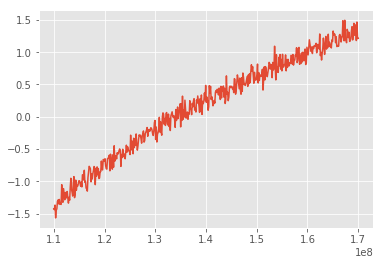

In [23]:
if False:
    true_tec = 0.1
    freqs_ = np.linspace(110e6,170e6,500)
    X = freqs_[:,None]
    X = X - X.mean()
    X /= X.std()
    Y = np.angle(np.exp(1j*true_tec*-8.4480e9/freqs_[:,None]))
    Y += 0.1*np.random.normal(size=Y.shape)
    Y = make_data_vec(Y, freqs_)
    plt.plot(freqs_,Y[:,0])
    plt.show()

    def make_hetero_svgp_model(X,Y,freqs,M=None,minibatch=None):
        N, num_latent = Y.shape
        M = M or N
        Z = kmeans2(X, M, minit='points')[0] if N < 10000 else X[np.random.choice(N,size=M,replace=False),:]
        Z_kern = kmeans2(X, 10, minit='points')[0] if N < 10000 else X[np.random.choice(N,size=10,replace=False),:]
        with gp.defer_build():
    #         periodic_kern = gp.kernels.Periodic(1,active_dims=[0],variance=1.)
    #         periodic_kern.variance.set_trainable(False)
            kern = gp.kernels.Polynomial(1,degree=1,active_dims=[0])

    #         Z = kmeans2(X, 10, minit='points')[0] if N < 10000 else X[np.random.choice(N,size=10,replace=False),:]
    #         kern = NonstationaryKernel(1, Z=Z_kern, hetero_sigma=False, hetero_ls=True,  active_dims=[0], name="nonstationary_kernel")
            likelihood = HeteroscedasticWrappedPhaseGaussian( 140e6,name='hetero_likelihood')
            mean = gp.mean_functions.Constant()
            error_latent = make_error_latent(M=10)
            model = HeteroscedasticSVGP(error_latent,X, Y, kern, likelihood, Z=Z, 
                        mean_function = mean, minibatch_size=minibatch,
                        num_latent=num_latent-1)

            var_list = [(model.q_mu, model.q_sqrt,XiSqrtMeanVar())]

    #         model.likelihood.variance = 0.2
    #         model.likelihood.variance.set_trainable(False)
            model.compile()
        return model, var_list
    with tf.Session(graph=tf.Graph()) as sess:
        model, vars = make_hetero_svgp_model(X,Y,freqs_,10,128)

    #     run_nat_grads_with_adam(model, 1e-2, 1e-3, iterations, 
    #                                 var_list=var_list, callback=PrintAction(model, '{} nat grads with Adam'.format(model.name)))

    #     print(model)
        gp.train.AdamOptimizer(1e-2).minimize(model)

        ystar,varstar = batch_predict_y_svgp(model,X,batch_size=1000)
        l = batch_predict_density_svgp(model,X,Y,batch_size=1000)
        print("likelihood {}".format(l))
        plot_single(X,Y,ystar,np.sqrt(varstar)*0, ax = None)
        plt.show()
        #     tec = model.predict_f_samples(X_t,1000)
        mean_tec, var_tec = model.predict_f(X)

